# A Introduction Bayesian optimization for chemical reactions with BayBE

BayBE is s a general-purpose toolbox for Bayesian Design of (chemical) experiments, developed by the pharmaceutical company Merck: https://emdgroup.github.io/baybe/stable/. Here, we will first introduce the basic functionality of this software package by focusing on a "dummy" experiment, after which you will be able to experiment on a real-world high-throughput experimentation dataset of Suzuki cross-coupling reactions.



In [ ]:
%load_ext autoreload
%autoreload 0

In [ ]:
!curl -O https://raw.githubusercontent.com/chimie-paristech-CTM/PSL_notebooks/main/bayesian_optimization/baybe_functions.py

In [ ]:
!pip install scikit-learn numpy==1.26 matplotlib scipy
!pip install baybe[chem,simulation]==0.12.2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from baybe import Campaign
from baybe.objectives import SingleTargetObjective
from baybe.parameters import NumericalDiscreteParameter, SubstanceParameter, NumericalContinuousParameter, TaskParameter
from baybe.recommenders import (
    BotorchRecommender,
    RandomRecommender,
    TwoPhaseMetaRecommender,
)
from baybe.constraints import ContinuousLinearConstraint, DiscreteCustomConstraint
from baybe.constraints.base import ContinuousNonlinearConstraint


from baybe.acquisition import qUpperConfidenceBound, qExpectedImprovement, qProbabilityOfImprovement, qLogExpectedImprovement

from baybe.searchspace import SearchSpace
from baybe.surrogates import GaussianProcessSurrogate
from baybe.surrogates.base import Surrogate
from baybe.targets import NumericalTarget
from baybe.utils.basic import get_subclasses
from baybe.utils.dataframe import add_fake_measurements
from baybe.utils.sampling_algorithms import DiscreteSamplingMethod

from baybe_functions import *

# A First optimization Campaign with BayBe

## 1. Setting up the search space

<h3> a. Defining molecules and Encoding </h3>

We focus here on an imaginary direct arylation reaction, where we are able to fine tune solvent, ligand, base as well as concentration and temperature. The first three variables are categorical, so we need to enumerate all the options for each of these variables first and foremost.

In [3]:
dict_solvent = {
    "DMAc": r"CC(N(C)C)=O",
    "Butyornitrile": r"CCCC#N",
    "Butyl Ester": r"CCCCOC(C)=O",
    "p-Xylene": r"CC1=CC=C(C)C=C1",
}

dict_base = {
    "Potassium acetate": r"O=C([O-])C.[K+]",
    "Potassium pivalate": r"O=C([O-])C(C)(C)C.[K+]",
    "Cesium acetate": r"O=C([O-])C.[Cs+]",
    "Cesium pivalate": r"O=C([O-])C(C)(C)C.[Cs+]",
}

dict_ligand = {
    "BrettPhos": r"CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC3)C4CCCCC4)C(OC)="
    "CC=C2OC",
    "Di-tert-butylphenylphosphine": r"CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C",
    "(t-Bu)PhCPhos": r"CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C3=CC=CC=C3",
}

Next, we need to define a numerical representation for each of the substances, i.e., we need to assign a vector to each compound. This will enable us to define a "distance" between individual compounds, and thus quantify the covariance between pairs of compounds.

Here, we will work with a MORDRED encoding (the default in BayBE). Mordred is a Python library used to compute molecular descriptors from chemical structures. A Mordred encoding of chemical compounds refers to the set of molecular descriptors generated using this library. These descriptors numerically represent various structural, topological, electronic, and physicochemical properties of a molecule, making them useful for machine learning, cheminformatics, and QSAR (Quantitative Structure-Activity Relationship) studies.

In [4]:
solvent = SubstanceParameter("Solvent", data=dict_solvent, encoding="MORDRED")
base = SubstanceParameter("Base", data=dict_base, encoding="MORDRED")
ligand = SubstanceParameter("Ligand", data=dict_ligand, encoding="MORDRED")

c:\Users\external\miniconda3\envs\bayesian\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3> b. Numerical parameters </h3>

Next, we proceed by defining the numerical variables. The numerical variables can be discrete or continuous with pre-defined bounds.

In [5]:
temperature = NumericalDiscreteParameter(
    "Temperature", values=[90, 105, 120], tolerance=2
)
concentration = NumericalDiscreteParameter(
    "Concentration", values=[0.057, 0.1, 0.153], tolerance=0.005
)
catalyst_loading = NumericalContinuousParameter(
    name="Catalyst Loading",
    bounds=(0.5, 5.0)
)

<h3> c. Adding constraints to the experiment </h3>

BayBE lets you mirror real-world experimental rules by **filtering** or **restricting** the space of possible experiments before optimization even begins. In practice, you define:


Continuous constraints
- Carve out valid regions of your numeric parameters.  
- **Example:** Forcing mixture components to sum to 1.0, or limiting how many reagents can be “active” at once (e.g. at least one and at most two non-zero concentrations).  
- Ensures the optimizer only proposes concentration or temperature combinations that actually make sense in the lab (e.g. no “negative” or impossible sums).

Discrete constraints
- Remove invalid categorical or grid-based combinations.  
- **Examples:**  
  - Ban known incompatibilities (e.g. a certain catalyst with high temperatures)  
  - Gate parameters behind an “on/off” switch (extra knobs only appear when the switch is “on”)  
  - Prevent duplicate selections across multiple reagent slots  
- Under the hood, BayBE enumerates all candidate combinations and then **filters** them against these rules so your optimizer never even sees the disallowed entries.


By layering these continuous and discrete filters—optionally tied to simple logical conditions —you precisely reflect your lab’s limitations (mixture fractions summing to unity, reagent–temperature incompatibilities, conditional parameters, etc.) while still letting the Bayesian engine focus on finding the best experiments.


In [6]:

# your solvent → boiling point map (°C)
dict_boiling_points = {
    "DMAc": 165.0,
    "Butyornitrile": 117.6,
    "Butyl Ester": 126.1,
    "p-Xylene": 138.35 
}

T_margin = 5.0  # °C safety margin

# Create a function which verifies if the expirement temperature meets the boiling point criteria
def solvent_bp_ok(df: pd.DataFrame) -> pd.Series:
    bp_series = df["Solvent"].map(dict_boiling_points)
    return df["Temperature"] <= (bp_series - T_margin)

# wrap it in a BayBE custom discrete‐space constraint
constraint_bp = DiscreteCustomConstraint(
    parameters=["Solvent", "Temperature"],
    validator=solvent_bp_ok
)

<h3> d. Set-up final search space </h3>

Finally, we can set up the search space. The term “search space” refers to the domain of possible values for the parameters that are being optimized during a campaign. A search space represents the space within which BayBE explores and searches for the optimal solution. It is implemented via the SearchSpace class.

In [ ]:
# Define list of parameters
parameters = [solvent, base, ligand, temperature, concentration, catalyst_loading]

# Construct Search Space of optimization model
searchspace = SearchSpace.from_product(parameters=parameters,
                                       constraints=[constraint_bp])


print(searchspace.type)



SearchSpaceType.HYBRID


ValueError: Provide the data to be transformed as first positional argument.

## 2. Defining the objective

In this example, we maximize the yield of a reaction and define a corresponding objective.

In [8]:
objective = SingleTargetObjective(target=NumericalTarget(name="yield", mode="MAX"))

## 3. Setting up the Bayesian Optimization campaign

Now, we can set up our Bayesian Optimization campaign. Initially, we have no data about the reaction, so we cannot apply a surrogate model to generate a prior, which can inform us about which experiment to prioritize. 

As such, some initial measurements will need to be made. We will start by performing random experiments.

In [9]:
# TODO: try out different recommenders. 
INITIAL_RECOMMENDER = RandomRecommender()

Once a couple of random experiments will have been performed, we will be able to set up the surrogate model and use an acquisition function to identify experiments to perform next. We will set this up below.

In [10]:
SURROGATE_MODEL = GaussianProcessSurrogate() # We will use Gaussian Processes as the surrogate to construct the prior

ACQ_FUNCTION = "qUCB" # upper confidence bound with a default beta of 0.2 is selected here for simplicity

Now that we have defined all the settings for the initial recommender as well as the "advanced" recommender, we can finalize the set-up of the campaign.

In [11]:
# TwoPhaseMetaRecommender, because we have two phases in the recommendations, 
# and the search space contains both discrete and continuous variables (i.e., it is a "meta" search space).

recommender = TwoPhaseMetaRecommender(
    initial_recommender=INITIAL_RECOMMENDER,
    recommender=BotorchRecommender(
        surrogate_model=SURROGATE_MODEL, acquisition_function=ACQ_FUNCTION
    ), switch_after=4
)

We can now take a closer look at the Recommender object we have created.

In [12]:
print(recommender)

TwoPhaseMetaRecommender
   Initial recommender
      RandomRecommender
         Compatibility: SearchSpaceType.HYBRID
   Recommender
      BotorchRecommender
         Surrogate
            GaussianProcessSurrogate
               Supports Transfer Learning: True
               Kernel factory: DefaultKernelFactory()
         Acquisition function: qUpperConfidenceBound(beta=0.2)
         Compatibility: SearchSpaceType.HYBRID
         Sequential continuous: True
         Hybrid sampler: None
         Sampling percentage: 1.0
   Switch after: 4
   Remain switched: False
   Has switched: False


Let's now change the beta for the UCB acquisition function.

In [25]:
ACQ_FUNCTON = qUpperConfidenceBound(beta=1.0)

recommender = TwoPhaseMetaRecommender(
    initial_recommender=INITIAL_RECOMMENDER,
    recommender=BotorchRecommender(
        surrogate_model=SURROGATE_MODEL, acquisition_function=ACQ_FUNCTON,
        sampling_percentage=0.3, hybrid_sampler=DiscreteSamplingMethod.Random
    ), switch_after=4
)

In [14]:
print(recommender)

TwoPhaseMetaRecommender
   Initial recommender
      RandomRecommender
         Compatibility: SearchSpaceType.HYBRID
   Recommender
      BotorchRecommender
         Surrogate
            GaussianProcessSurrogate
               Supports Transfer Learning: True
               Kernel factory: DefaultKernelFactory()
         Acquisition function: qUpperConfidenceBound(beta=1.0)
         Compatibility: SearchSpaceType.HYBRID
         Sequential continuous: True
         Hybrid sampler: DiscreteSamplingMethod.Random
         Sampling percentage: 0.3
   Switch after: 4
   Remain switched: False
   Has switched: False


Finally, we can set up the BO campaign.

In [26]:
campaign = Campaign(
    searchspace=searchspace,
    recommender=recommender,
    objective=objective,
)

In [28]:
import pandas as pd
from baybe.parameters import CustomDiscreteParameter

descriptors = pd.DataFrame(
    {
        "Glass_Transition_TempC": [20, -71, -39],
        "Weight_kDalton": [120, 32, 241],
    },
    index=["Polymer A", "Polymer B", "Polymer C"],  # put labels in the index
)

param = CustomDiscreteParameter(
    name="Polymer",
    data=descriptors,
    active_values=(  # optional, enforces that only Polymer A or C is recommended
        "Polymer A",
        "Polymer C",
    ),
    decorrelate=True,  # optional, uses default correlation threshold
)

print(param)

{'Name': 'Polymer', 'Type': 'CustomDiscreteParameter', 'nValues': 3, 'Encoding': <CustomEncoding.CUSTOM: 'CUSTOM'>, 'nActiveValues': 2}


## 4. Running the campaign

We can now run the campaign straightforwardly. We start by getting initial recommendations from the model.

In [ ]:
recommendation = campaign.recommend(batch_size=4)
print("\n\nRecommended experiments: ")
print(recommendation)




Recommended experiments: 
         Solvent                Base                        Ligand  \
21   Butyl Ester      Cesium acetate  Di-tert-butylphenylphosphine   
40   Butyl Ester     Cesium pivalate                     BrettPhos   
348     p-Xylene   Potassium acetate                 (t-Bu)PhCPhos   
374     p-Xylene  Potassium pivalate                 (t-Bu)PhCPhos   

     Temperature  Concentration  Catalyst Loading  
21         105.0          0.057          2.534433  
40         105.0          0.100          3.326323  
348        120.0          0.057          2.829736  
374        105.0          0.153          4.314675  
     Base_MORDRED_ABC  Base_MORDRED_ATS0Z  Base_MORDRED_ATSC1Z  \
21           2.449490              3228.0           187.625000   
40           4.876566              3342.0            22.615917   
348          2.449490               564.0             3.125000   
374          4.876566               678.0           -26.837370   

     Base_MORDRED_ATSC4Z  Base

c:\Users\external\miniconda3\envs\bayesian\lib\site-packages\baybe\searchspace\discrete.py:604: DeprecationWarning: For backward compatibility, the new `allow_extra` flag is set to `True` when left unspecified. However, this behavior will be changed in a future version. If you want to invoke the old behavior, please explicitly set `allow_extra=True`.
  warnings.warn(


Since we are not going to run the experiments in reality, we are going to feed "fake" measurements back to the model. We use a custom/artificial optimal reference of input parameters. This will serve for the fake measurements to converge slowly to the optimal input parameters with the best yield.

IMPORTANT NOTE: In real life cases, the optimal input parameters and yield will not be known before optimization.

In [18]:
# Potential reference values as optimum (used for campaign generation --> usually UNKOWN)
optimal_reference = {
    "Solvent":           ["DMAc"],
    "Base":              ["Cesium pivalate"],
    "Ligand":            ["BrettPhos"],
    "Temperature":       [120, 90],
    "Concentration":     [0.10],
    "Catalyst Loading":  [1.0]
    }


# Add some fake measurements to drive optimization algorithm
add_fake_measurements_arti(recommendation, searchspace, campaign.targets, good_reference_values=optimal_reference,
                      good_intervals={"yield":(85, 95)}, bad_intervals={"yield":(50, 65)})

# Print results
print("\n\nRecommended experiments with fake measured values: ")
print(recommendation)

# Acquire current max yield as measure to drive algorithm (for adding fake measurements)
current_max = np.max(recommendation['yield'])

# Print current maximum
print("\n\nCurrent maximum yield:")
print(f"{current_max:.3f}")

# Add created recommendations to current campaign
campaign.add_measurements(recommendation)



Recommended experiments with fake measured values: 
           Solvent                Base                        Ligand  \
173  Butyornitrile  Potassium pivalate                     BrettPhos   
286           DMAc  Potassium pivalate  Di-tert-butylphenylphosphine   
228           DMAc     Cesium pivalate  Di-tert-butylphenylphosphine   
61     Butyl Ester   Potassium acetate                 (t-Bu)PhCPhos   

     Temperature  Concentration  Catalyst Loading      yield  
173        105.0          0.153          2.353082  61.940584  
286        120.0          0.100          1.515281  72.002963  
228        105.0          0.057          2.798937  74.837996  
61         120.0          0.100          2.649521  66.182575  


Current maximum yield:
74.838


In [19]:
# Current maximum
global_max = current_max

# TODO: Continue the campaign by adding some additional experiments.
for i in range(1, 21):
    print(f'round {i}...')
    recommendation = campaign.recommend(batch_size=2)

    # Add new measurements with respect to maximum already found and reference optimal
    maximum_bounds = {"yield":(85, 95)}
    bad_yields = {"yield":(50, 65)}
    add_fake_measurements_arti(recommendation, searchspace, campaign.targets, good_reference_values=optimal_reference,
                          good_intervals=maximum_bounds, bad_intervals=bad_yields)

    # Feed them back into the campaign so the surrogate updates
    campaign.add_measurements(recommendation)

    # print and update your global best yield
    print("\nRecommended experiments with fake measured values:")
    print(recommendation)
    
    # Acquire current max yield as measure to drive algorithm
    current_max = np.max(recommendation['yield'])

    # Update global maximum if new experiments yield better results
    if current_max > global_max:
        global_max = current_max

    print(f"\nCurrent maximum yield so far: {global_max:.3f}")
    print()

round 1...

Recommended experiments with fake measured values:
      Solvent             Base                        Ligand  Temperature  \
index                                                                       
231      DMAc  Cesium pivalate  Di-tert-butylphenylphosphine        120.0   
225      DMAc  Cesium pivalate  Di-tert-butylphenylphosphine         90.0   

       Concentration  Catalyst Loading      yield  
index                                              
231            0.057          2.783044  71.094130  
225            0.057          1.679987  76.997633  

Current maximum yield so far: 76.998

round 2...

Recommended experiments with fake measured values:
      Solvent                Base                        Ligand  Temperature  \
index                                                                          
226      DMAc     Cesium pivalate  Di-tert-butylphenylphosphine         90.0   
287      DMAc  Potassium pivalate  Di-tert-butylphenylphosphine        120.0  

In [40]:
print(optimal_reference.items())

# Retrieve the DataFrame of all measurements
results_df = campaign.measurements # or campaign.data

# Suppose your target column is named "objective_value":
best_idx = results_df["yield"].idxmax()
best_row = results_df.loc[best_idx]

# If you just want the parameter values as a dictionary:
best_params = best_row.drop("yield").to_dict()
print("Best observed parameters:", best_params)
print("Corresponding objective:", best_row["yield"])

dict_items([('Solvent', ['DMAc']), ('Base', ['Cesium pivalate']), ('Ligand', ['BrettPhos']), ('Temperature', [120, 90]), ('Concentration', [0.1]), ('Catalyst Loading', [1.0])])
Best observed parameters: {'Solvent': 'DMAc', 'Base': 'Cesium pivalate', 'Ligand': 'BrettPhos', 'Temperature': 90.0, 'Concentration': 0.1, 'Catalyst Loading': 0.5, 'BatchNr': 6, 'FitNr': 6.0}
Corresponding objective: 87.05372423655682


This figure shows the Gaussian Process posterior over our reaction yield as a function of the experiment index. The solid line traces the model’s predicted mean yield for each candidate point, while the shaded band represents ±1 standard deviation of uncertainty around that mean. Early on, the model is more uncertain (wider bands), reflecting sparse data; as more measurements are added, uncertainty shrinks and the mean prediction converges toward the true optimum. This visualization helps illustrate how the GP balances exploration (high uncertainty) and exploitation (high predicted mean) during optimization.  


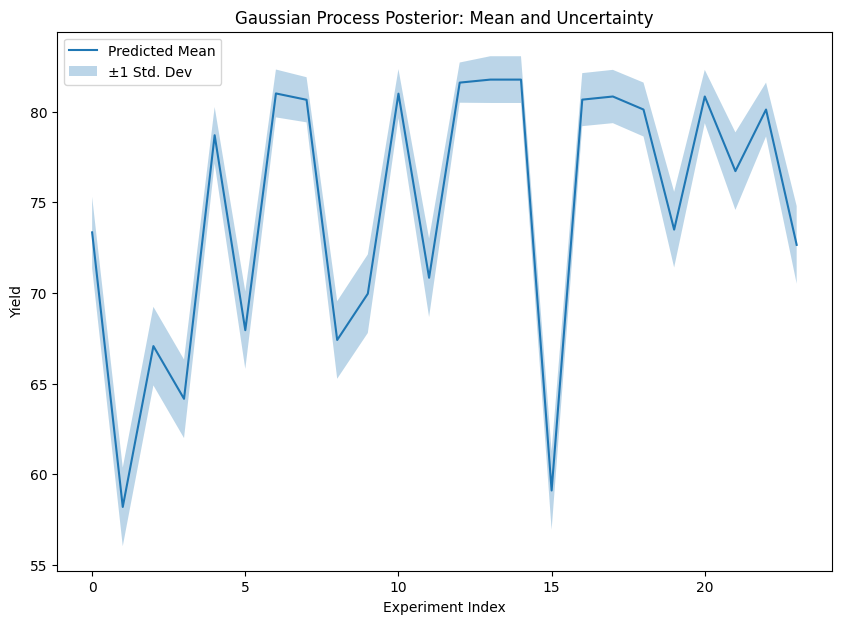

In [39]:
# Retreive posterior statistics results
results = campaign.posterior_stats()

# Extract x-axis (experiment index) and the GP posterior statistics
x = results.index
y = results['yield_mean']
yerr = results['yield_std']

# Plot the GP posterior mean with ±1 standard deviation bounds
plt.figure(figsize=(10,7))
plt.plot(x, y, label='Predicted Mean')
plt.fill_between(x, y - yerr, y + yerr, alpha=0.3, label='±1 Std. Dev')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Gaussian Process Posterior: Mean and Uncertainty')
plt.legend()
plt.show()